In [1]:
from IPython.core.display import Image, display
display(Image(url='https://www.greekmythology.com/images/mythology/aegis_228.jpg', width=200, unconfined=True))

/tmp/ipykernel_379203/4129434108.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [2]:
import numpy as np
import healpy as hp
import pickle as pk
import torch
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import seaborn as sns
from os import listdir
import os
import sys
sys.path.append('../astroLFI')
import LFI_galactic_center
from sources import FermiBackgrounds
from sources import Model_O
from sources import DMsignal
from sources import smoothDM
from sources import MSP
from sources import Fermi_Bubbles
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from getdist import plots, MCSamples

%matplotlib inline

In [3]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5 + 20*2 #kpc
#exposure = 10*2000*10*0.2 #cm^2 yr
exposure = 2000*10*0.2 #cm^2 yr
#exposure = 200*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
#flux_cut = np.inf
angular_cut = 10*u.deg.to('rad') #degrees
angular_cut_gen = angular_cut*1.5
lat_cut = 2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [4]:
# Add core non-poisson millisecond pulsar source clase
start1_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
my_MSP = MSP.MSP(spec_file_path)
def R_core_np_wrap(r, params):
    A = params[start1_i]
    #A = 0.035
    r_s = 20 #kpc
    gamma = 1.2
    return A * my_MSP.gNFW(r, r_s, gamma)**2

def Theta_core_np_wrap(theta, params):
    return np.ones(np.shape(theta))
    #return np.concatenate((np.zeros(np.round(np.size(theta)/2).astype('int')), np.ones(np.round(np.size(theta)/2).astype('int')-1)))
    #return np.sin(theta)**10

def Phi_core_np_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_core_np_wrap(L, params):
    n_1 = -0.66
    n_2 = 18.2
    #L_b = params[start1_i+1] #1e34
    L_b = 1.56e37/2.35 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_core_np_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{core}')
parameter_range[0].append(0.)
parameter_range[1].append(0.07)
#parameter_range[0].append(5e33)
#parameter_range[1].append(1.5e34)
MSP_core_np_als = [(R_core_np_wrap, Theta_core_np_wrap, Phi_core_np_wrap), L_core_np_wrap, spec_core_np_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_core_np_als)
source_class_list.append('independent_spherical_multi_spectra')

In [ ]:
# Add core poisson millisecond pulsar source clase
start1_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
my_MSP = MSP.MSP(spec_file_path)
def R_core_p_wrap(r, params):
    A = params[start1_i]
    #A = 1.0
    r_s = 20 #kpc
    gamma = 1.2
    return A * my_MSP.gNFW(r, r_s, gamma)**2

def Theta_core_p_wrap(theta, params):
    return np.ones(np.shape(theta))
    #return np.concatenate((np.zeros(np.round(np.size(theta)/2).astype('int')), np.ones(np.round(np.size(theta)/2).astype('int')-1)))
    #return np.sin(theta)**10

def Phi_core_p_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_core_p_wrap(L, params):
    n_1 = 0.97
    n_2 = 2.6
    #L_b = params[start1_i+1] #1e34
    L_b = 1.061e36/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_core_p_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{core}')
parameter_range[0].append(0.)
parameter_range[1].append(3.)
#parameter_range[0].append(5e33)
#parameter_range[1].append(1.5e34)
MSP_core_p_als = [(R_core_p_wrap, Theta_core_p_wrap, Phi_core_p_wrap), L_core_p_wrap, spec_core_p_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_core_p_als)
source_class_list.append('independent_spherical_multi_spectra')

In [5]:
# Add disk non-poisson millisecond pulsar source clase
start2_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
disk_file_path = '../data/MSP/Buschmann_etal_2020_fig7_disk.csv'
GCE_file_path = '../data/MSP/Buschmann_etal_2020_fig7_GCE.csv'
my_MSP = MSP.MSP(spec_file_path)
disk_to_GCE_source_count_ratio = my_MSP.get_disk_to_GCE_source_count_ratio(disk_file_path, GCE_file_path)
print('non-poisson disk excpected source count = ', 970*disk_to_GCE_source_count_ratio)
def R_disk_np_wrap(r, params):
    A = params[start2_i]
    #A = 0.25
    r_d = 5 #kpc
    gamma = 1.2
    return A * my_MSP.disk_R_MS(r, r_d)

def Z_disk_np_wrap(z, params):
    z_s = 0.3 #kpc
    return my_MSP.disk_Z_MS(z, z_s)

def Phi_disk_np_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_disk_np_wrap(L, params):
    n_1 = -0.66
    n_2 = 18.2
    #L_b = params[1] #1e34
    L_b = 1.56e37/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_disk_np_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{disk}')
parameter_range[0].append(0.)
parameter_range[1].append(2.)
MSP_disk_np_als = [(R_disk_np_wrap, Z_disk_np_wrap, Phi_disk_np_wrap), L_disk_np_wrap, spec_disk_np_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_disk_np_als)
source_class_list.append('independent_cylindrical_multi_spectra')

non-poisson disk excpected source count =  1.8533745787762563


In [ ]:
# Add disk poisson millisecond pulsar source clase
start2_i = np.size(parameter_range[0])
spec_file_path = '../data/MSP/1407_5583.txt'
mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
disk_file_path = '../data/MSP/Buschmann_etal_2020_fig7_disk.csv'
GCE_file_path = '../data/MSP/Buschmann_etal_2020_fig7_GCE.csv'
my_MSP = MSP.MSP(spec_file_path)
disk_to_GCE_source_count_ratio = my_MSP.get_disk_to_GCE_source_count_ratio(disk_file_path, GCE_file_path)
print('poisson disk excpected source count = ', 2.6e4*disk_to_GCE_source_count_ratio)
def R_disk_p_wrap(r, params):
    A = params[start2_i]
    #A = 5.0
    r_d = 5 #kpc
    gamma = 1.2
    return A * my_MSP.disk_R_MS(r, r_d)

def Z_disk_p_wrap(z, params):
    z_s = 0.3 #kpc
    return my_MSP.disk_Z_MS(z, z_s)

def Phi_disk_p_wrap(phi, params):
    return np.ones(np.shape(phi))

def L_disk_p_wrap(L, params):
    n_1 = 0.97
    n_2 = 2.60
    #L_b = params[1] #1e34
    L_b = 1.061e36/2.25 #photons/s
    return my_MSP.luminosity_bpl(L, n_1, n_2, L_b)

def spec_disk_p_wrap(energy, num_spectra, params):
    #return my_MSP.MSP_spectra_load(energy, mean_spec_file_path, num_spectra)
    return my_MSP.MSP_spectra(energy, num_spectra)

parameter_names.append('A_{disk}')
parameter_range[0].append(0.)
parameter_range[1].append(15.)
MSP_disk_p_als = [(R_disk_p_wrap, Z_disk_p_wrap, Phi_disk_p_wrap), L_disk_p_wrap, spec_disk_p_wrap]
abundance_luminosity_and_spectrum_list.append(MSP_disk_p_als)
source_class_list.append('independent_cylindrical_multi_spectra')

In [6]:
# Add dark matter halo signal
start3_i = np.size(parameter_range[0])
N_side_DM = 2**8
N_Ebins_DM = 100
settings = {'N_side': N_side_DM, 'theta_cutoff': angular_cut, 'halo_dist': 8.5*u.kpc.to('cm'), 'Rs': 20*u.kpc.to('cm'), 'mass_func': 'gNFW'}
my_DM_flux = smoothDM.smoothDM(**settings)
channel = 'b'
DM_directory = '../data/dm_spectra/'
my_DM_signal = DMsignal.DMsignal(DM_directory, channel)
fix_spec_to_MSP_mean = False

def DM_wrap(params):
    DM_mass = params[start3_i] #MeV
    #DM_mass = 30000 #MeV
    cross_sec = params[start3_i + 1]*1e-26 #cm^3 s^-1
    #cross_sec = params[start3_i]*1e-26 #cm^3 s^-1
    rho_s = 1.06e-2*u.Msun.to('kg')*c.c.value**2*u.J.to('MeV')/u.pc.to('cm')**3
    r_s = 20*u.kpc.to('cm')
    gamma = 1.2
    DM_energies = np.geomspace(energy_range[0], energy_range[1], N_Ebins_DM+1) #MeV
    dNdE = my_DM_signal.get_dNdE(DM_energies, channel, DM_mass)
    if fix_spec_to_MSP_mean:
        spec_file_path = '../data/MSP/1407_5583.txt'
        mean_spec_file_path = '../data/MSP/mean_spectrum.npy'
        my_MSP = MSP.MSP(spec_file_path)
        mean_spec = my_MSP.MSP_spectra_load(DM_energies, mean_spec_file_path, 1)[0,:]
        dNdE = mean_spec*np.sum(dNdE[:-1]*(DM_energies[1:]-DM_energies[:-1]))
    mass_func_params = (r_s, rho_s, gamma)
    DM_map, DM_indices = my_DM_flux.get_map(DM_mass, cross_sec, dNdE, mass_func_params)
    return DM_map.T, DM_energies, DM_indices, N_side_DM

parameter_names.append(r'm_{\chi}')
parameter_range[0].append(10000.)
parameter_range[1].append(100000.)
parameter_names.append(r'\langle\sigma_{DM} v\rangle_0')
parameter_range[0].append(0.)
parameter_range[1].append(10.0)
DM_als = [DM_wrap]
abundance_luminosity_and_spectrum_list.append(DM_als)
source_class_list.append('healpix_map')

In [7]:
# Add Fermi isotropic background source class
my_FB = FermiBackgrounds.FermiBackgrounds('..')
def spec_iso_wrap(energy, params):
    iso_fit = my_FB.get_isotropic_background_spectrum_func()
    return iso_fit(energy)
FIB_als = [spec_iso_wrap]
abundance_luminosity_and_spectrum_list.append(FIB_als)
source_class_list.append('isotropic_diffuse')

In [ ]:
# Add Fermi nonisotropic background source class
my_FB = FermiBackgrounds.FermiBackgrounds('..')
N_side_FB = 2**9
N_Ebins = 1500
FB_map, FB_energies, FB_indices = my_FB.get_partial_nonistropic_background(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins, N_side_FB)
'''
FNB_dict = my_FB.get_nonistropic_background(N_side_FB = 2**10)
map_all = FNB_dict['galactic_bg']
map_E = FNB_dict['energies_MeV']
gal_bg_data = pk.load(open('../data/FermiData/galactic_bg_healpix_Nside128.pk','rb'))
map_all = gal_bg_data['galactic_bg']
map_E = gal_bg_data['energies_MeV']
'''

def FNB_wrap(params):
    return FB_map, FB_energies, FB_indices, N_side_FB

FNB_als = [FNB_wrap]
abundance_luminosity_and_spectrum_list.append(FNB_als)
source_class_list.append('healpix_map')

parameter_names = ['A_{core}', 'A_{disk}', r'm_{\chi}', r'\langle\sigma_{DM} v\rangle_0', r'A_{O}']
parameter_range = [[0., 0., 500000., 0., 0.5], [0.07, 2., 1000000., 30., 1.5]] #nonpoisson extendedDM2
#parameter_range = [[0., 0., 500000., 0., 0.5], [3., 15., 1000000., 30., 1.5]] #poisson extendedDM
#parameter_range = [[0., 0., 400000., 0., 0.5], [0.07, 2., 800000., 30., 1.5]] #nonpoisson limitedDM
#parameter_range = [[0., 0., 400000., 0., 0.5], [3., 15., 800000., 30., 1.5]] #poisson limitedDM

In [8]:
# Add Model O source class
start4_i = np.size(parameter_range[0])
N_side_MO = 2**8
N_Ebins_MO = 1500
my_MO = Model_O.Model_O('..')

# inverse compton scattering model:
MO_ics_map, MO_ics_energies, MO_ics_indices = my_MO.get_partial_map_ics(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_MO, N_side_MO)
def MO_ics_wrap(params):
    A_O = 1
    #A_O = params[start4_i]
    return A_O*MO_ics_map, MO_ics_energies, MO_ics_indices, N_side_MO

MO_ics_als = [MO_ics_wrap]
abundance_luminosity_and_spectrum_list.append(MO_ics_als)
source_class_list.append('healpix_map')

# pi^0 + Bremsstrahlung model:
MO_pibrem_map, MO_pibrem_energies, MO_pibrem_indices = my_MO.get_partial_map_pibrem(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_MO, N_side_MO)
def MO_pibrem_wrap(params):
    A_O = 1
    #A_O = params[start4_i]
    return A_O*MO_pibrem_map, MO_pibrem_energies, MO_pibrem_indices, N_side_MO

#parameter_names.append(r'A_{O}')
#parameter_range[0].append(0.5)
#parameter_range[1].append(1.5)
MO_pibrem_als = [MO_pibrem_wrap]
abundance_luminosity_and_spectrum_list.append(MO_pibrem_als)
source_class_list.append('healpix_map')

In [9]:
display(Image(url='https://cdn.shopify.com/s/files/1/0605/9520/8383/files/logo-modelo_008b34f4-c9a9-4164-a0b8-f8950a4c79b9_large.png?v=1638135925', width=200, unconfined=True))
my_MO = Model_O.Model_O('..')

In [10]:
# Add Fermi Bubbles source class
my_FBub = Fermi_Bubbles.Fermi_Bubbles('..')
N_side_FBub = 2**8
N_Ebins_FBub = 1500

FBub_map, FBub_energies, FBub_indices = my_FBub.get_partial_map(angular_cut_gen, energy_range_gen[0], energy_range_gen[1], N_Ebins_FBub, N_side_FBub)
def FBub_wrap(params):
    return FBub_map, FBub_energies, FBub_indices, N_side_FBub

FBub_als = [FBub_wrap]
abundance_luminosity_and_spectrum_list.append(FBub_als)
source_class_list.append('healpix_map')

In [11]:
my_LFI = LFI_galactic_center.LFI_G(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, verbose = False)
my_LFI.angular_cut_gen, my_LFI.lat_cut_gen, my_LFI.Emin_gen, my_LFI.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:724: RuntimeWarning: invalid value encountered in divide
  y_cdfs = np.cumsum(pdf, axis = 1)/np.tile(np.sum(pdf, axis = 1), (np.size(pdf[0,:]),1)).T
/tmp/ipykernel_379203/2084249112.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(), shrink = 0.67, label = 'Photons', ticks = np.round(np.linspace(0, np.max(heatmap[0]), 10)).astype('int'), boundaries = np.linspace(0, np.max(heatmap[0]), 100), values = np.linspace(1, 10, 99))


Max count in any pixel/energy bin:  235.0
Number of sources:  628
Number of photons:  57407
Average photon energy:  4.665294035880829  GeV
Average luminosity/source (only valid when running single source):  1.7950119507578728e+34 $ erg s^{-1}$
Approximate Flux:  3.399306370179149e-09 $ erg cm^{-2}s^{-1}$
Number of pixels:  280
Size of pixels (deg): 0.9161297098179749


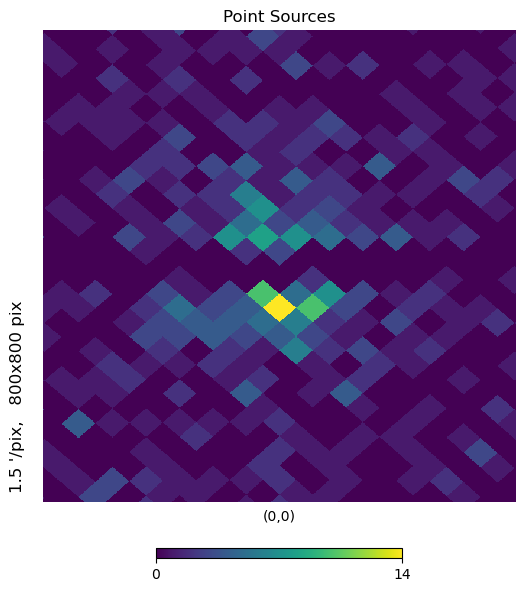

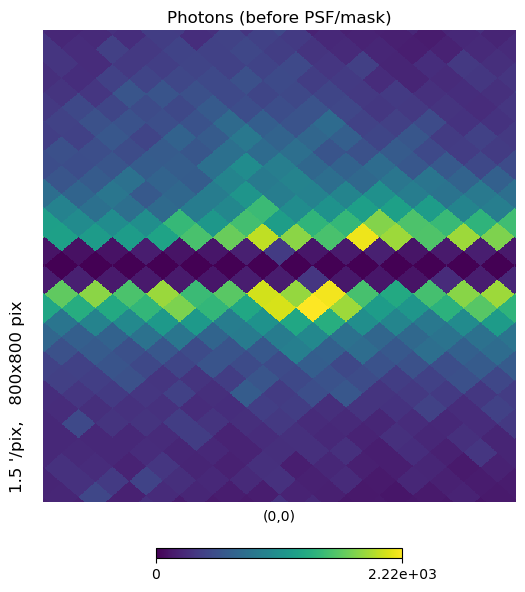

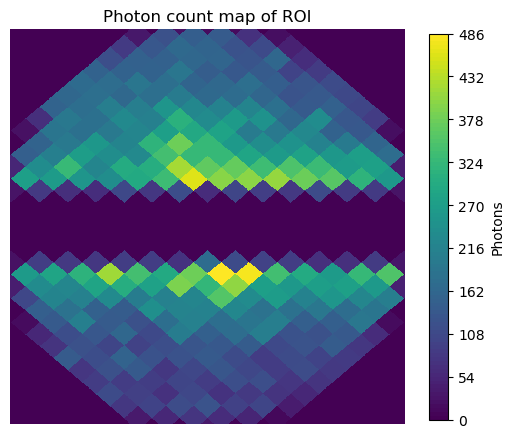

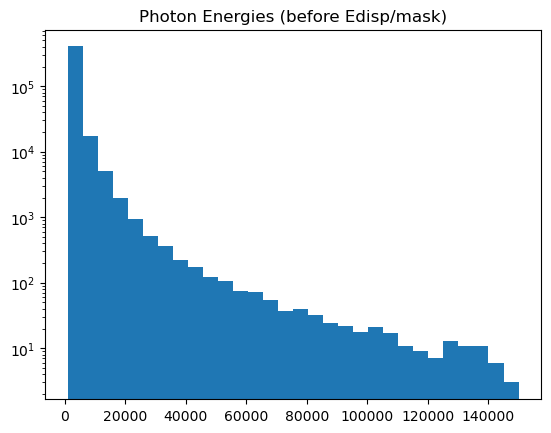

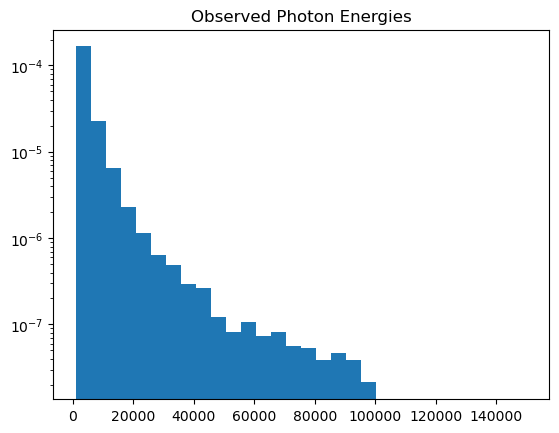

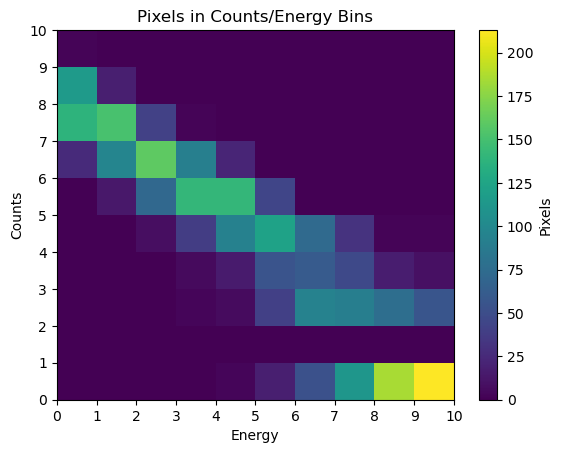

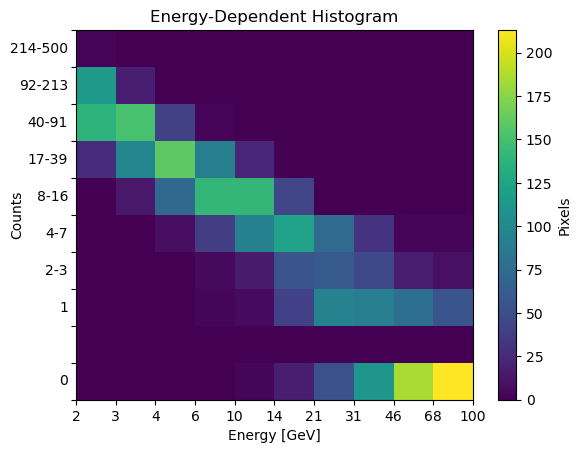

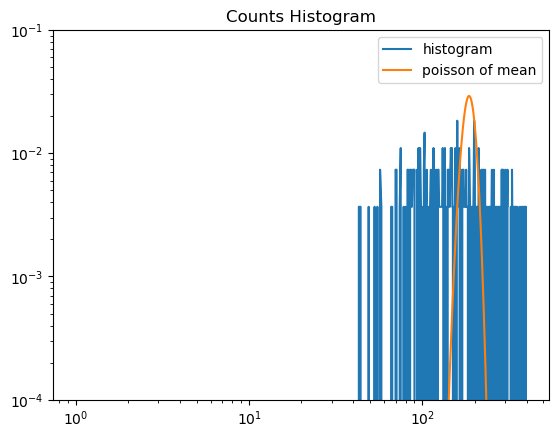

In [12]:
#input_params = [1.0, 5.0] #poisson only pulsars, only number normalizations
#input_params = [0.035, 0.25] #non-poisson only pulsars, only number normalizations
#input_params = [70000, 3] #DM mass and cross section
#input_params = [2., 6.0, 30000, 0] #poisson pulsars, only number normalizations, DM mass and cross section
input_params = [0.022, 0.25, 30000, 1] #nonpoisson pulsars, only number normalizations, DM mass and cross section
#input_params = [0.035, 0.25, 30000, 3, 1] #nonpoisson pulsars, only number normalizations, DM mass and cross section, Model O normalization
#input_params = [1., 3] #poisson run 6
#input_params = [0.035, 3] #nonpoisson run 6

source_info = my_LFI.create_sources(input_params, grains = 10000)
photon_info = my_LFI.generate_photons_from_sources(input_params, source_info)
obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Point Sources', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Photons (before PSF/mask)', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5)

heatmap = np.histogram(hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.gnomview(heatmap[0], title = 'Photon count map of ROI', xsize = int(round(2*angular_cut*u.rad.to('arcmin')/1.5)), reso = 1.5, notext = True, cbar = None)
plt.colorbar(cm.ScalarMappable(), shrink = 0.67, label = 'Photons', ticks = np.round(np.linspace(0, np.max(heatmap[0]), 10)).astype('int'), boundaries = np.linspace(0, np.max(heatmap[0]), 100), values = np.linspace(1, 10, 99))
#plt.savefig('figures/ROI_map_hist.pdf', bbox_inches='tight', pad_inches = 0)

fig, ax = plt.subplots()
ax.set_title('Photon Energies (before Edisp/mask)')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

fig, ax = plt.subplots()
ax.set_title('Observed Photon Energies')
ax.set_yscale('log')
#ax.set_xscale('log')
ax.hist(obs_photon_info['energies'], bins = 30, range = energy_range_gen, density = True)

N_Ebins = 10
roi_map = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins = N_Ebins, Ebinspace = 'log')
Ebins = np.geomspace(my_LFI.Emin_mask + 0.1, my_LFI.Emax_mask + 0.1, N_Ebins + 1) - 0.1
print('Max count in any pixel/energy bin: ', np.max(roi_map))
mincount, maxcount, N_countbins = 0, 500, 10
counts_hist = my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = mincount, maxcount = maxcount, N_countbins = N_countbins, countbinspace = 'log')
countbins = np.geomspace(mincount + 0.1, maxcount + 0.1, N_countbins + 1) - 0.1
fig, ax = plt.subplots()
ax.set_title('Pixels in Counts/Energy Bins')
ax.set_xlabel('Energy')
ax.set_ylabel('Counts')
ax.set_xticks(np.linspace(0, N_Ebins, N_Ebins+1))
ax.set_yticks(np.linspace(0, N_countbins, N_countbins+1))
mesh = ax.pcolormesh(counts_hist)
fig.colorbar(mesh, label = 'Pixels')
#fig.savefig('figures/histogram_summary.pdf', bbox_inches='tight', pad_inches = 0)

fig, ax = plt.subplots()
ax.set_title('Energy-Dependent Histogram')
ax.set_xlabel('Energy [GeV]')
ax.set_ylabel('Counts', labelpad = 30)
ax.set_xticks(np.linspace(0, N_Ebins, N_Ebins+1))
ax.set_yticks(np.linspace(0, N_countbins, N_countbins+1))
ax.set_xticklabels(np.round(Ebins/1000).astype('int'))
count_ints = np.round(countbins).astype('int')
count_labels = ['0','','1']
for i, edge in enumerate(count_ints):
    if i > 2 and i < N_countbins:
        count_labels.append(str(count_ints[i]+1)+'-'+str(count_ints[i+1]))
for i, label in enumerate(count_labels):
    ax.annotate(count_labels[i], xy=(0, 0), xycoords=('axes fraction', 'axes fraction'),
        xytext=(-0.02, 0.05+0.1*i), va='center', ha='right')
ax.yaxis.set_major_formatter(ticker.NullFormatter())
mesh = ax.pcolormesh(counts_hist)
fig.colorbar(mesh, label = 'Pixels')
#fig.savefig('figures/histogram_summary_labeled.pdf', bbox_inches='tight', pad_inches = 0)

fig, ax = plt.subplots()
ax.set_title('Counts Histogram')
for i in range(1):
    source_info = my_LFI.create_sources(input_params, grains = 10000)
    photon_info = my_LFI.generate_photons_from_sources(input_params, source_info)
    obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    roi_map = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins = 1, Ebinspace = 'log')
    if i == 0:
        counts_hist = my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 400, N_countbins = 400, countbinspace = 'linear')
    else:
        counts_hist += my_LFI.get_counts_histogram_from_roi_map(roi_map, mincount = 0, maxcount = 400, N_countbins = 400, countbinspace = 'linear')
counts_hist /= np.sum(counts_hist)
counts_bins = np.linspace(0, 400, 401)
ax.plot(counts_bins[:-1], counts_hist, label = 'histogram')
mean = np.sum(counts_hist.T[0]*counts_bins[:-1])
plotc = np.linspace(0, 400, 401)
import scipy as sp
ax.plot(plotc, sp.stats.poisson.pmf(plotc, mean), label = 'poisson of mean')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-4, 1e-1)
ax.legend()

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(obs_photon_info['energies']))
print('Average photon energy: ', np.mean(obs_photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source (only valid when running single source): ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(obs_photon_info['energies'])*u.MeV.to('erg')*np.size(obs_photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Number of pixels: ', roi_map.shape[0])#round(12*N_side**2*(2*np.pi*(1 - np.cos(angular_cut)))/(4*np.pi)))
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))

In [16]:
#overplot of contours

#input_params = torch.tensor([1., 3.0, 30000, 1]) #poisson 50/50
#input_params = torch.tensor([2., 6.0, 80000, 0]) #poisson no DM
#input_params = torch.tensor([0., 0., 30000, 2]) #poisson no PS
#input_params = torch.tensor([0.022, 0.25, 30000, 1]) #non-poisson 50/50
#input_params = torch.tensor([0.044, 0.5, 30000, 0]) #non-poisson no DM
input_params = torch.tensor([0., 0., 30000, 2]) #non-poisson no PS

#file = 'figures/bias_poisson_5050.pdf'
#file = 'figures/bias_poisson_noDM.pdf'
#file = 'figures/bias_poisson_noPS.pdf'
#file = 'figures/bias_nonpoisson_5050.pdf'
#file = 'figures/bias_nonpoisson_noDM.pdf'
file = 'figures/bias_nonpoisson_noPS.pdf'

static_observation = True #prevents simulator(s) from generating unique photons when called if True
def simulator(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_counts.flatten()
def simulator3(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 1
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return heatmap_counts.flatten()
def simulator4(params):
    params = params.numpy()
    N_side = 2**6
    N_Ebins = 10
    mincount = 0
    maxcount = 650
    N_countbins = 10
    source_info = my_LFI.create_sources(params, grains = 4000)
    photon_info = my_LFI.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    #obs_photon_info = my_LFI.mock_observe(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_exposure(photon_info, obs_info)
    obs_photon_info = my_LFI.apply_PSF(obs_photon_info, obs_info, single_energy_psf = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_energy_dispersion(obs_photon_info, obs_info, single_energy_ed = False, single_energy_value = None)
    obs_photon_info = my_LFI.apply_mask(obs_photon_info, obs_info)
    if static_observation:
        obs_photon_info = static_obs_photon_info
    #heatmap = my_LFI.get_partial_map_summary(obs_photon_info, N_side, N_Ebins)[0]
    heatmap_roi = my_LFI.get_roi_map_summary(obs_photon_info, N_side, N_Ebins, Ebinspace = 'log')
    heatmap_counts = my_LFI.get_counts_histogram_from_roi_map(heatmap_roi, mincount, maxcount, N_countbins, countbinspace = 'log')
    heatmap_combined = np.concatenate((heatmap_roi.flatten(), heatmap_counts.flatten()))
    return np.sum(heatmap_roi, axis = 0)

In [17]:
#mean values and standard deviations

network1 = 'run9a_nonpoisson/100000sims'
network2 = 'run9p_nonpoisson/100000sims'
network3 = 'run9b_nonpoisson/100000sims'
network4 = 'run9c_nonpoisson/100000sims'
num_sims = 100
num_samples = 10000
means1 = np.zeros((num_sims, np.size(parameter_range[0])))
stds1 = np.zeros((num_sims, np.size(parameter_range[0])))
means2 = np.zeros((num_sims, np.size(parameter_range[0])))
stds2 = np.zeros((num_sims, np.size(parameter_range[0])))
means3 = np.zeros((num_sims, np.size(parameter_range[0])))
stds3 = np.zeros((num_sims, np.size(parameter_range[0])))
means4 = np.zeros((num_sims, np.size(parameter_range[0])))
stds4 = np.zeros((num_sims, np.size(parameter_range[0])))
posterior_file1 = 'posteriors/' + network1
posterior1 = np.load(posterior_file1 + '.npy', allow_pickle=True)[()]
posterior_file2 = 'posteriors/' + network2
posterior2 = np.load(posterior_file2 + '.npy', allow_pickle=True)[()]
posterior_file3 = 'posteriors/' + network3
posterior3 = np.load(posterior_file3 + '.npy', allow_pickle=True)[()]
posterior_file4 = 'posteriors/' + network4
posterior4 = np.load(posterior_file4 + '.npy', allow_pickle=True)[()]
for i in range(num_sims):
    static_source_info = my_LFI.create_sources(input_params.numpy(), grains = 4000)
    static_photon_info = my_LFI.generate_photons_from_sources(input_params.numpy(), static_source_info, grains = 1000)
    static_obs_info = {'psf_fits_path': '../paper2/paper2_data/Fermi_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../paper2/paper2_data/Fermi_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    static_obs_photon_info = my_LFI.mock_observe(static_photon_info, static_obs_info)
    observation = simulator(input_params)
    observation3 = simulator3(input_params)
    observation4 = simulator4(input_params)
    samples1 = posterior1.sample((num_samples,), x=observation).numpy()
    means1[i,:] = np.sum(samples1, axis = 0)/num_samples
    stds1[i,:] = np.sqrt(np.sum((np.tile(means1[i,:], (num_samples, 1)) - samples1)**2, axis = 0)/(num_samples - 1))
    samples2 = posterior2.sample((num_samples,), x=observation).numpy()
    means2[i,:] = np.sum(samples2, axis = 0)/num_samples
    stds2[i,:] = np.sqrt(np.sum((np.tile(means2[i,:], (num_samples, 1)) - samples2)**2, axis = 0)/(num_samples - 1))
    samples3 = posterior3.sample((num_samples,), x=observation3).numpy()
    means3[i,:] = np.sum(samples3, axis = 0)/num_samples
    stds3[i,:] = np.sqrt(np.sum((np.tile(means3[i,:], (num_samples, 1)) - samples3)**2, axis = 0)/(num_samples - 1))
    samples4 = posterior4.sample((num_samples,), x=observation4).numpy()
    means4[i,:] = np.sum(samples4, axis = 0)/num_samples
    stds4[i,:] = np.sqrt(np.sum((np.tile(means4[i,:], (num_samples, 1)) - samples4)**2, axis = 0)/(num_samples - 1))
sim_means1 = np.sum(means1, axis = 0)/num_sims
sim_stds1 = np.sqrt(np.sum(stds1**2, axis = 0))/num_sims
sim_means2 = np.sum(means2, axis = 0)/num_sims
sim_stds2 = np.sqrt(np.sum(stds2**2, axis = 0))/num_sims
sim_means3 = np.sum(means3, axis = 0)/num_sims
sim_stds3 = np.sqrt(np.sum(stds3**2, axis = 0))/num_sims
sim_means4 = np.sum(means4, axis = 0)/num_sims
sim_stds4 = np.sqrt(np.sum(stds4**2, axis = 0))/num_sims
print(sim_means1)
print(sim_stds1)
print(sim_means2)
print(sim_stds2)
print(sim_means3)
print(sim_stds3)
print(sim_means4)
print(sim_stds4)

/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:1044: RuntimeWarning: invalid value encountered in divide
  r_i = self.draw_from_pdf(r, r_integral/np.sum(r_integral), N_draws)
/home/chri3448/EPDF_ABC/gc_jobs/../astroLFI/LFI_galactic_center.py:1060: RuntimeWarning: invalid value encountered in divide
  r_i = self.draw_from_pdf(r, r_integral/np.sum(r_integral), N_draws)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[1.03025702e-02 9.74818252e-01 2.77698962e+04 1.59367832e+00]
[6.37028465e-04 4.77066782e-02 3.72305415e+02 2.76525477e-02]
[1.03901203e-02 9.79469778e-01 2.74471021e+04 1.66486368e+00]
[5.90547709e-04 4.73028804e-02 3.15509099e+02 2.51229561e-02]
[1.80279749e-02 9.88089519e-01 6.18755597e+04 2.09115213e+00]
[1.22171218e-03 5.38417468e-02 2.63540156e+03 9.32552061e-02]
[1.30106276e-02 1.00448423e+00 2.64318314e+04 1.45455782e+00]
[7.72982179e-04 5.48892854e-02 3.25409590e+02 3.09007546e-02]


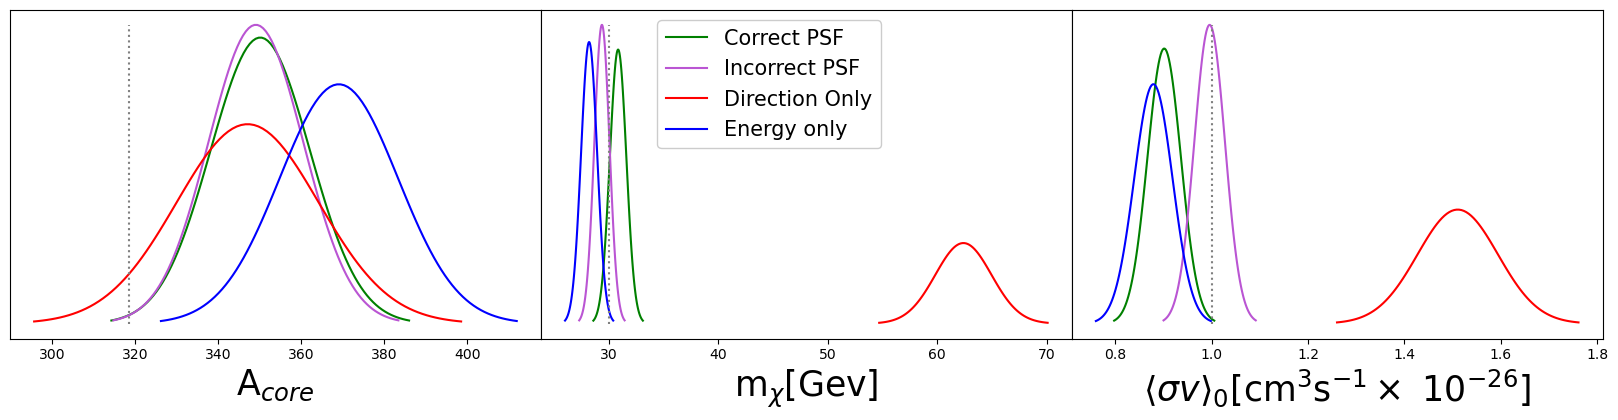

In [15]:
#50/50 plot

fig, ax = plt.subplots(1,3,figsize=(16,4))
#fig.suptitle('nonpoisson', fontsize=20)
A_core_conversion_fac = 14482.4 #nonpoisson
sigmav_conversion_fac = 1
new_parameter_range = [[A_core_conversion_fac*parameter_range[0][0], 0.001*parameter_range[0][2], sigmav_conversion_fac*parameter_range[0][3]], [A_core_conversion_fac*parameter_range[1][0], 0.001*parameter_range[1][2], sigmav_conversion_fac*6]]
new_parameter_names = [r'A$_{core}$', r'm$_\chi$[Gev]', r'$\langle\sigma v\rangle_0$[cm$^3$s$^{-1}\times$ 10$^{-26}$]']
new_markers = [A_core_conversion_fac*input_params[0], 0.001*input_params[2], sigmav_conversion_fac*input_params[3]]
maxy = [0,0,0]

#run9a_nonpoisson/100000sims
#means = np.array([2.43275146e-02, 3.06928288e+04, 9.11767630e-01])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.38570139e-04, 7.12418522e+02, 3.54177458e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#means = np.array([2.44568414e-02, 3.12507635e+04, 9.19215516e-01])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.42079442e-04, 7.46833033e+02, 3.55703540e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
means = [2.41778119e-02, 3.08566417e+04, 9.01581951e-01]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [8.24297777e-04, 7.54173238e+02, 3.46168358e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Correct PSF', color = 'g')
    
#run9p_nonpoisson/100000sims
#means = np.array([2.36111953e-02, 3.05378334e+04, 1.04033364e+00])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.04235709e-04, 7.10943061e+02, 3.29523361e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#means = np.array([2.44562254e-02, 3.12496291e+04, 9.19024059e-01])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.42982542e-04, 7.45757063e+02, 3.55935625e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
means = [2.41055227e-02, 2.93771937e+04, 9.95848313e-01]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [7.89167896e-04, 6.91804601e+02, 3.18723260e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Incorrect PSF', color = 'mediumorchid')

#run9b_nonpoisson/100000sims
means = [2.39684469e-02, 6.23997049e+04, 1.51057024e+00]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [1.18226867e-03, 2.56414121e+03, 8.34924157e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Direction Only', color = 'r')

#run9c_nonpoisson/100000sims
means = [2.54836167e-02, 2.82069921e+04, 8.79143010e-01]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [9.85196590e-04, 7.34059647e+02, 3.97723176e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Energy only', color = 'b')

for i in range(3):
    ax[i].set_xlabel(new_parameter_names[i], fontsize = 25)
    ax[i].vlines(x=new_markers[i],ymin=0,ymax=maxy[i], color = 'gray', linestyle = 'dotted')
    ax[i].tick_params(axis='y', which='both', left = False, right = False, labelleft = False)
fig.tight_layout(pad = 0)
ax[1].legend(bbox_to_anchor=(.2, 1), fontsize = 15, framealpha = 1)

In [65]:
#fig.savefig('figures/bias.pdf')

In [ ]:
#noPS plot

fig, ax = plt.subplots(1,3,figsize=(16,4))
#fig.suptitle('nonpoisson', fontsize=20)
A_core_conversion_fac = 14482.4 #nonpoisson
sigmav_conversion_fac = 1
new_parameter_range = [[A_core_conversion_fac*parameter_range[0][0], 0.001*parameter_range[0][2], sigmav_conversion_fac*parameter_range[0][3]], [A_core_conversion_fac*parameter_range[1][0], 0.001*parameter_range[1][2], sigmav_conversion_fac*6]]
new_parameter_names = [r'A$_{core}$', r'm$_\chi$[Gev]', r'$\langle\sigma v\rangle_0$[cm$^3$s$^{-1}\times$ 10$^{-26}$]']
new_markers = [A_core_conversion_fac*input_params[0], 0.001*input_params[2], sigmav_conversion_fac*input_params[3]]
maxy = [0,0,0]

#run9a_nonpoisson/100000sims
#means = np.array([2.43275146e-02, 3.06928288e+04, 9.11767630e-01])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.38570139e-04, 7.12418522e+02, 3.54177458e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#means = np.array([2.44568414e-02, 3.12507635e+04, 9.19215516e-01])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.42079442e-04, 7.46833033e+02, 3.55703540e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
means = [2.41778119e-02, 3.08566417e+04, 9.01581951e-01]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [8.24297777e-04, 7.54173238e+02, 3.46168358e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Correct PSF', color = 'g')
    
#run9p_nonpoisson/100000sims
#means = np.array([2.36111953e-02, 3.05378334e+04, 1.04033364e+00])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.04235709e-04, 7.10943061e+02, 3.29523361e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#means = np.array([2.44562254e-02, 3.12496291e+04, 9.19024059e-01])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
#sigs =  np.array([8.42982542e-04, 7.45757063e+02, 3.55935625e-02])*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
means = [2.41055227e-02, 2.93771937e+04, 9.95848313e-01]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [7.89167896e-04, 6.91804601e+02, 3.18723260e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Incorrect PSF', color = 'mediumorchid')

#run9b_nonpoisson/100000sims
means = [2.39684469e-02, 6.23997049e+04, 1.51057024e+00]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [1.18226867e-03, 2.56414121e+03, 8.34924157e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Direction Only', color = 'r')

#run9c_nonpoisson/100000sims
means = [2.54836167e-02, 2.82069921e+04, 8.79143010e-01]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
sigs =  [9.85196590e-04, 7.34059647e+02, 3.97723176e-02]*np.array([A_core_conversion_fac, 0.001, sigmav_conversion_fac])
for i in range(3):
    x = np.linspace(means[i]-3*sigs[i], means[i]+3*sigs[i], 100)
    y = 1/(sigs[i]*2*np.pi)*np.exp(-.5*((means[i]-x)/sigs[i])**2)
    maxy[i] = max(maxy[i], *y)
    ax[i].plot(x,y, label = 'Energy only', color = 'b')

for i in range(3):
    ax[i].set_xlabel(new_parameter_names[i], fontsize = 25)
    ax[i].vlines(x=new_markers[i],ymin=0,ymax=maxy[i], color = 'gray', linestyle = 'dotted')
    ax[i].tick_params(axis='y', which='both', left = False, right = False, labelleft = False)
fig.tight_layout(pad = 0)
ax[1].legend(bbox_to_anchor=(.2, 1), fontsize = 15, framealpha = 1)